In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from copy import deepcopy



## Generate a 2D Dataset (Two Moons)
We'll start by generating a simple 2D dataset, like the "two moons" shape, using scikit-learn:

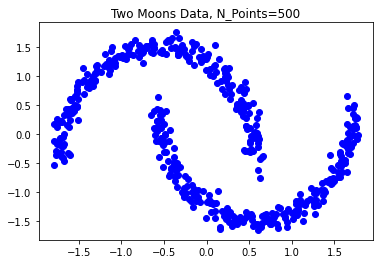

In [6]:
from datasets import (
    TwoMoonsDataset,
    TwoCirclesDataset,
    GaussianBlobsDataset,
    SwissRollDataset,
    SpiralDataset,
    StarDataset,
    HeartDataset,
    CircleDataset,
    LineDataset,
    WaveDataset,
)


n_points = 500

twomoons_tr_dataset = TwoMoonsDataset(n_samples=5000, n_points=500, noise=0.05)
twomoons_vl_dataset = TwoMoonsDataset(n_samples=500 , n_points=500, noise=0.05)
twomoons_te_dataset = TwoMoonsDataset(n_samples=1000, n_points=500, noise=0.05)

# Set the batch size
batch_size = 64

# Create a DataLoader
dataloader_tr = DataLoader(twomoons_tr_dataset, batch_size=batch_size, shuffle=True)
dataloader_vl = DataLoader(twomoons_vl_dataset, batch_size=batch_size, shuffle=False)
dataloader_te = DataLoader(twomoons_te_dataset, batch_size=batch_size, shuffle=False)

# Generate two moons data
data = next(iter(dataloader_tr))

batch_idx = 0
plt.scatter(data[batch_idx, :, 0], data[batch_idx, :, 1], c='blue')
plt.title(f'Two Moons Data, N_Points={data.shape[1]}')
plt.show()

## Define the DDPM Framework
Next, we'll define the core components of the DDPM: the forward process (adding noise) and the reverse process (denoising).

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from embeddings import SinusoidalPositionEmbeddings, PointEmbedder
from schedules import cosine_beta_schedule

class MLP(nn.Module):
    def __init__(self, embed_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        
        self.time_embedding = SinusoidalPositionEmbeddings(dim=embed_dim)
        self.point_embedding = PointEmbedder(input_dim=2, embedding_dim=embed_dim)

        self.model = nn.Sequential(
            nn.Linear(2*embed_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, xy, t):
        t = self.time_embedding(t)
        xy = self.point_embedding(xy)
        xyt = torch.cat([xy, t.unsqueeze(1).repeat(1, xy.shape[1], 1)], axis=-1)
        return self.model(xyt)


class DDPM(nn.Module):
    def __init__(self, 
                 timesteps=1000, 
                 beta_min=0.0001,
                 beta_max=0.02,
                 hidden_dim=64,
                 criterion=nn.MSELoss(), 
                 device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
        super(DDPM, self).__init__()
        self.device = device
        self.criterion = criterion
        self.timesteps = timesteps
        # self.betas = torch.linspace(beta_min, beta_max, timesteps).to(device)
        self.betas = cosine_beta_schedule(beta_start=beta_min, beta_end=beta_max, timesteps=timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), self.alphas_cumprod[:-1]], axis=0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)

        self.model = MLP(embed_dim=16, hidden_dim=hidden_dim, output_dim=2).to(device)

    def forward_diffusion(self, x_0, t):
        noise = torch.randn_like(x_0)
        sqrt_alpha_cumprod_t = self.alphas_cumprod[t].sqrt().unsqueeze(1).unsqueeze(1)
        sqrt_one_minus_alpha_cumprod_t = (1.0 - self.alphas_cumprod[t]).sqrt().unsqueeze(1).unsqueeze(1)
        return sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise, noise

    def reverse_diffusion(self, x_t, t):
        mean = (1.0 / self.sqrt_recip_alphas[t]) * (x_t - self.betas[t] / (1.0 - self.alphas_cumprod[t]).sqrt() * self.model(x_t, t))
        noise = torch.randn_like(x_t) if t > 0 else 0
        return mean + (self.posterior_variance[t].sqrt() * noise)

    def loss(self, x_0, t):
        x_t, noise = self.forward_diffusion(x_0, t)
        predicted_noise = self.model(x_t, t)
        return self.criterion(predicted_noise, noise)


## Prepare model for training

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

timesteps = 500
learning_rate = 1e-5


# Initialize the model, optimizer, and loss function
criterion = nn.MSELoss()
ddpm = DDPM(
    timesteps=timesteps,
    beta_min=0.0001,
    beta_max=0.01,
    hidden_dim=128,
    criterion=criterion).to(device)
# optimizer = optim.Adam(ddpm.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(ddpm.parameters(), lr=0.1, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** epoch)

## Forward Process

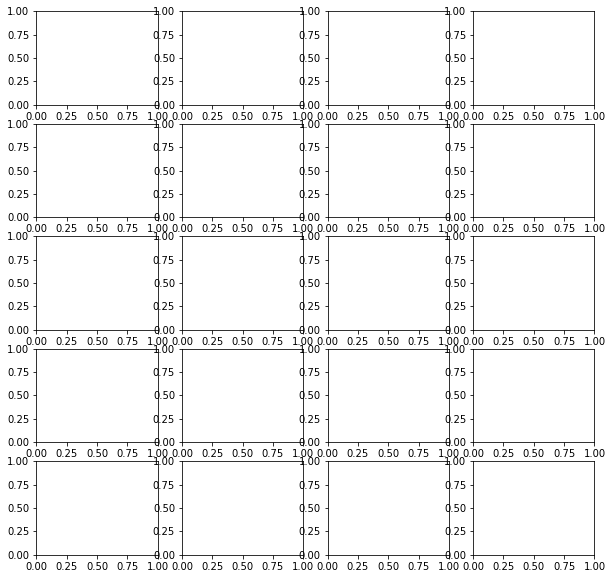

In [9]:
_, axs = plt.subplots(5, 4, figsize=(10, 10))



## Training the Model
Now, let's train the DDPM on the two moons dataset.

In [10]:
epochs = 500

tqdm.write('Training the model...')
pbar = tqdm(range(epochs), desc='Epochs')


tr_losses, vl_losses = [], []
best_loss = np.inf

# Training loop
for epoch in pbar:
    tr_itr_losses = []
    for data in dataloader_tr:
        x_0 = data.to(device)
        t = torch.randint(0, timesteps, (x_0.shape[0],), device=x_0.device)
        
        loss = ddpm.loss(x_0, t)
        tr_itr_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mean_tr_loss = np.mean(tr_itr_losses)
    tr_losses.append(mean_tr_loss)
    
    with torch.no_grad():
        vl_itr_losses = []
        for data in dataloader_vl:
            x_0 = data.to(device)
            t = torch.randint(0, timesteps, (x_0.shape[0],), device=x_0.device)
            loss = ddpm.loss(x_0, t)
            vl_itr_losses.append(loss.item())
        mean_vl_loss = np.mean(vl_itr_losses)

        pbar.set_postfix({'Validation Loss': mean_vl_loss})
        vl_losses.append(mean_vl_loss)

        if mean_vl_loss < best_loss:
            best_loss = mean_vl_loss
            best_ddpm = deepcopy(ddpm)
            # torch.save(ddpm.state_dict(), 'ddpm_best.pth')

    pbar.set_description(f'Epoch {epoch + 1}/{epochs}, Tr_Loss: {mean_tr_loss:0.5f}, Vl_Loss: {mean_vl_loss:0.5f}')


plt.plot(tr_losses, label='Training Loss')
plt.plot(vl_losses, label='Validation Loss')
plt.legend()
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

Training the model...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Sampling from the Model
After training, we can sample points from the model to reconstruct the original data distribution.

timesteps: 1000


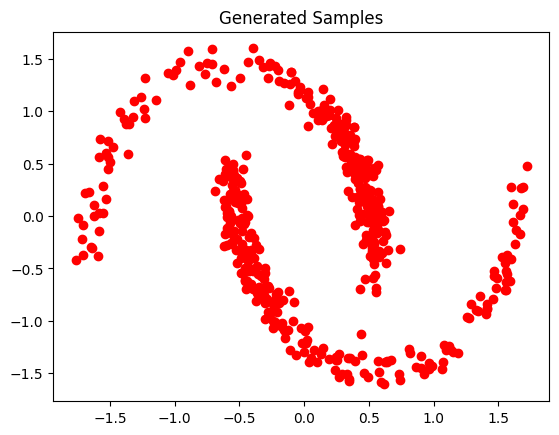

In [ ]:
def sample(ddpm, timesteps, n_points=n_points):
    x = torch.randn((1, n_points, 2), device=device)
    for t in reversed(range(timesteps)):
        x = ddpm.reverse_diffusion(x, torch.tensor([t], device=device))
    return x.detach().cpu().numpy()

print(f"timesteps: {timesteps}")
samples = sample(ddpm, timesteps=timesteps)[0]

plt.scatter(samples[:, 0], samples[:, 1], c='red')
plt.title('Generated Samples')
plt.show()


## Visualizing the Process
To visualize how the diffusion process perturbs the data and how the model denoises it, you can save intermediate images or create an animation.

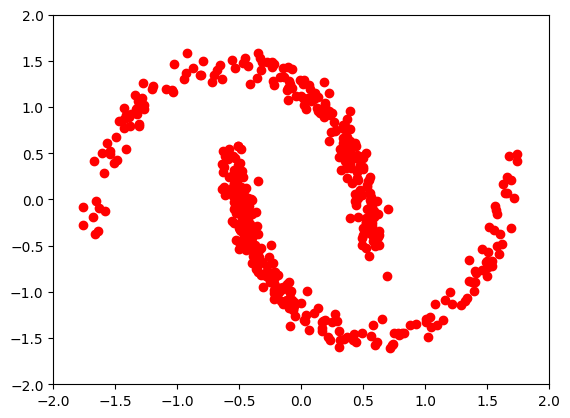

In [ ]:
import matplotlib.animation as animation


class Animation:
    def __init__(self, n_points, timesteps, device, ddpm):
        self.x = torch.randn((1, n_points, 2), device=device)
        self.timesteps = timesteps
        self.ddpm = ddpm
        self.device = device

    def init(self):
        line.set_data([], [])
        return line,

    def animate(self, i):
        t = self.timesteps - i - 1
        self.x = self.ddpm.reverse_diffusion(self.x, torch.tensor([t], device=self.device))
        data = self.x.detach().cpu().numpy()[0]
        line.set_data(data[:, 0], data[:, 1])
        return line,

fig, ax = plt.subplots()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

line, = ax.plot([], [], 'ro')

anim_obj = Animation(n_points, timesteps, device, ddpm)


ani = animation.FuncAnimation(fig, anim_obj.animate, init_func=anim_obj.init, frames=timesteps, interval=50, blit=True)
ani.save('ddpm_sampling.mp4', writer='ffmpeg', fps=50)

# To display in Jupyter (or skip if running as a script)
from IPython.display import Video
Video('ddpm_sampling.mp4')
